In [1]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langchain_openai import AzureChatOpenAI
from dotenv import load_dotenv

In [2]:
load_dotenv()

True

In [3]:
class ParentState(TypedDict):

    question: str
    answer_eng: str
    answer_hin: str

In [4]:
parent_llm = AzureChatOpenAI(model='gpt-4o-mini')
subgraph_llm = AzureChatOpenAI(model='gpt-4o-mini')

In [5]:
def translate_text(state: ParentState):

    prompt = f"""
Translate the following text to Hindi.
Keep it natural and clear. Do not add extra content.

Text:
{state["answer_eng"]}
""".strip()
    
    translated_text = subgraph_llm.invoke(prompt).content

    return {'answer_hin': translated_text}

In [6]:
subgraph_builder = StateGraph(ParentState)

subgraph_builder.add_node('translate_text', translate_text)

subgraph_builder.add_edge(START, 'translate_text')
subgraph_builder.add_edge('translate_text', END)

subgraph = subgraph_builder.compile()

In [7]:
def generate_answer(state: ParentState):

    answer = parent_llm.invoke(f"You are a helpful assistant. Answer clearly.\n\nQuestion: {state['question']}").content
    return {'answer_eng': answer}

In [8]:
parent_builder = StateGraph(ParentState)

parent_builder.add_node("answer", generate_answer)
parent_builder.add_node("translate", subgraph)

parent_builder.add_edge(START, 'answer')
parent_builder.add_edge('answer', 'translate')
parent_builder.add_edge('translate', END)

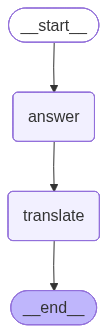

In [9]:
graph = parent_builder.compile()

graph

In [10]:
graph.invoke({'question': 'What is quantum physics'})

{'question': 'What is quantum physics',
 'answer_eng': 'Quantum physics, also known as quantum mechanics, is a fundamental branch of physics that describes the behavior of matter and energy at very small scales, typically at the level of atoms and subatomic particles. It is characterized by several key principles, including:\n\n1. **Wave-Particle Duality**: Particles, such as electrons and photons, exhibit both particle-like and wave-like properties depending on how they are observed.\n\n2. **Quantization**: Energy and certain properties (like angular momentum) can only take on discrete values, or "quanta," rather than a continuous range.\n\n3. **Uncertainty Principle**: Formulated by Werner Heisenberg, this principle states that certain pairs of properties, such as position and momentum, cannot both be precisely measured at the same time.\n\n4. **Superposition**: Particles can exist in multiple states or configurations simultaneously until an observation is made.\n\n5. **Entanglement*